Inspired from [this notebook](https://github.com/spiridonoff/Monet/blob/main/CycleGAN.ipynb)

In [1]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import itertools
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
class Arguments():
    # main parameters

    # Root directory for dataset
    dataroot_A = "../data/photo_jpg/"
    dataroot_B = "../data/monet_jpg/"
    
    dataroot_test_A = "../data/photo_jpg_test/"

    # Number of workers for dataloader
    workers = 4

    # Batch size during training
    batch_size = 4

    # Spatial size of training images. All images will be resized to this
    #   size using a transformer.
    image_size = 256

    # Number of channels in the group A
    input_nc = 3
    
    # Number of channels in the group B
    output_nc = 3

    # number of filters in the last conv layer of generator
    ngf = 32

    # number of filters in the first conv layer of discriminator
    ndf = 16

    # Number of training epochs
    n_epochs = 20

    # Learning rate for optimizers
    lr = 0.0002
    
    # identity_loss coeff.
    lambda_identity = .5
    lambda_A = 10.0
    lambda_B = 10.0

    # Beta1 hyperparam for Adam optimizers
    beta1 = 0.5

    # Number of GPUs available. Use 0 for CPU mode.
    ngpu = 1
    
    gan_mode = 'lsgan' # 'vanilla', 'wgangp'
    
    pool_size = 16

    device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    print(device)
    
    print_freq = 1
    save_freq = 5
    save_dir = "models/"
opt = Arguments()

cuda:0


In [3]:
# to empty up the memory in GPU
torch.cuda.empty_cache()

In [4]:
# create a dataset to return pairs of images from both 2 styles
class UnpairedDataset(torch.utils.data.Dataset):
    def __init__(self, opt):
        self.path_A = opt.dataroot_A
        self.path_B = opt.dataroot_B
        
        transform = transforms.Compose([
            transforms.Resize(opt.image_size),
            transforms.CenterCrop(opt.image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        
        self.datasetA = dset.ImageFolder(root = self.path_A, transform = transform)
        self.datasetB = dset.ImageFolder(root = self.path_B, transform = transform)
        
        self.size_A = len(self.datasetA)
        self.size_B = len(self.datasetB)

    def __len__(self):
        return max(self.size_A, self.size_B)

    def __getitem__(self, index):
        A_tensor = self.datasetA[index % self.size_A][0]
        
        index_B = random.randint(0, self.size_B - 1)
        B_tensor = self.datasetB[index_B][0]
        
        return {'A': A_tensor, 'B': B_tensor}

In [5]:
unpaired_dataset = UnpairedDataset(opt)
dataloader = torch.utils.data.DataLoader(unpaired_dataset, batch_size=opt.batch_size, shuffle=True, num_workers=opt.workers)

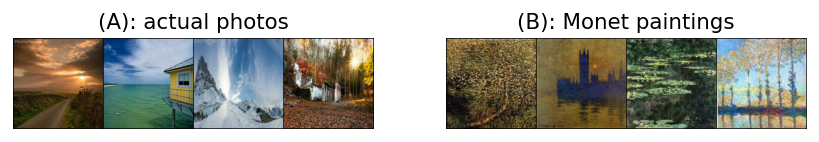

In [6]:
# visualize a batch of data
real_batch = next(iter(dataloader))

plt.figure(figsize=(8,4), dpi=128)
plt.subplot(1,2,1)
plt.axis("off")
plt.title("(A): actual photos")

grid_A = vutils.make_grid(real_batch['A'], padding=2, normalize=True, nrow=4).cpu()
plt.imshow(np.transpose(grid_A,(1,2,0)))

plt.subplot(1,2,2)
# plt.figure(figsize=(16,4), dpi=128)
plt.axis("off")
plt.title("(B): Monet paintings")
grid_B = vutils.make_grid(real_batch['B'], padding=2, normalize=True, nrow=4).cpu()
plt.imshow(np.transpose(grid_B,(1,2,0)))

In [7]:
dataset_test = dset.ImageFolder(
    root = opt.dataroot_test_A,
    transform = transforms.Compose([
        transforms.Resize(opt.image_size),
        transforms.CenterCrop(opt.image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]))

dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=4, shuffle=False, num_workers=0)

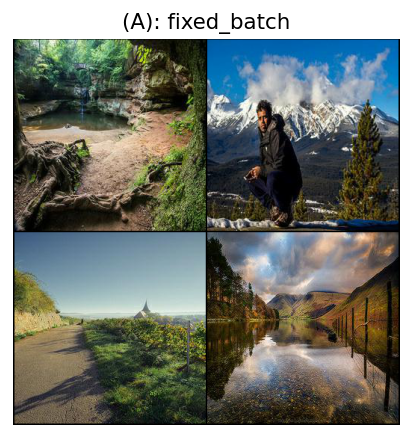

In [8]:
# fixed batch used to visualize the evolution of the network over training
fixed_test_batch = next(iter(dataloader_test))[0].to(opt.device)

plt.figure(figsize=(4,4), dpi=128)
plt.axis("off")
plt.title("(A): fixed_batch")
grid_fixed = vutils.make_grid(fixed_test_batch, padding=2, normalize=True, nrow=2).cpu()
plt.imshow(np.transpose(grid_fixed,(1,2,0)))

In [9]:
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf):
        """
        Parameters:
            input_nc (int) -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            ngf (int) -- the number of filters in the last conv layer
        Returns a generator
        """
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Down sampling
            nn.Conv2d(input_nc, ngf, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size.  ngf x (image_size/2) x (image_size/2)
            
            nn.Conv2d(ngf, ngf*2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ngf*2 x (image_size/4) x (image_size/4)
            
            nn.Conv2d(ngf*2, ngf*4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ngf*4 x (image_size/8) x (image_size/8)
            
            nn.Conv2d(ngf*4, ngf*8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ngf*8 x (image_size/16) x (image_size/16)
            
            # ---
            # Up sampling
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ngf*2 x (image_size/4) x (image_size/4)
            
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x image_size/2 x image_size/2
            
            nn.ConvTranspose2d(ngf, output_nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (output_nc) x image_size x image_size
        )

    def forward(self, input):
        return self.main(input)

In [10]:
class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.
    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """
    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        """Construct a Resnet-based generator
        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        
        use_bias = False
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block
        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.
        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not
        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out

In [11]:
# Discriminator Code    
class Discriminator(nn.Module):
    def __init__(self, input_nc, ndf):
        """
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
        """
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (input_nc) x image_size x image_size
            nn.Conv2d(input_nc, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x image_size/2 x image_size/2
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x image_size/4 x image_size/4
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x image_size/8 x image_size/8
            
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x image_size/16 x image_size/16
            
#             nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 16),
#             nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x image_size/32 x image_size/32
            
#             nn.Conv2d(ndf * 16, ndf * 32, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 32),
#             nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*32) x image_size/64 x image_size/64
            
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [12]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [13]:
class GANLoss(nn.Module):
    """Define different GAN objectives.

    The GANLoss class abstracts away the need to create the target label tensor
    that has the same size as the input.
    """

    def __init__(self, gan_mode, target_real_label=1.0, target_fake_label=0.0):
        """ Initialize the GANLoss class.

        Parameters:
            gan_mode (str) - - the type of GAN objective. It currently supports vanilla, lsgan, and wgangp.
            target_real_label (bool) - - label for a real image
            target_fake_label (bool) - - label of a fake image

        Note: Do not use sigmoid as the last layer of Discriminator.
        LSGAN needs no sigmoid. vanilla GANs will handle it with BCEWithLogitsLoss.
        """
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.gan_mode = gan_mode
        if gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode in ['wgangp']:
            self.loss = None
        else:
            raise NotImplementedError('gan mode %s not implemented' % gan_mode)

    def get_target_tensor(self, prediction, target_is_real):
        """Create label tensors with the same size as the input.

        Parameters:
            prediction (tensor) - - tpyically the prediction from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images

        Returns:
            A label tensor filled with ground truth label, and with the size of the input
        """

        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):
        """Calculate loss given Discriminator's output and ground truth labels.

        Parameters:
            prediction (tensor) - - tpyically the prediction output from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images

        Returns:
            the calculated loss.
        """
        if self.gan_mode in ['lsgan', 'vanilla']:
            target_tensor = self.get_target_tensor(prediction, target_is_real)
            loss = self.loss(prediction, target_tensor)
        elif self.gan_mode == 'wgangp':
            if target_is_real:
                loss = -prediction.mean()
            else:
                loss = prediction.mean()
        return loss

In [14]:
class ImagePool():
    """This class implements an image buffer that stores previously generated images.

    This buffer enables us to update discriminators using a history of generated images
    rather than the ones produced by the latest generators.
    """

    def __init__(self, pool_size):
        """Initialize the ImagePool class

        Parameters:
            pool_size (int) -- the size of image buffer, if pool_size=0, no buffer will be created
        """
        self.pool_size = pool_size
        if self.pool_size > 0:  # create an empty pool
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        """Return an image from the pool.

        Parameters:
            images: the latest generated images from the generator

        Returns images from the buffer.

        By 50/100, the buffer will return input images.
        By 50/100, the buffer will return images previously stored in the buffer,
        and insert the current images to the buffer.
        """
        if self.pool_size == 0:  # if the buffer size is 0, do nothing
            return images
        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)
            if self.num_imgs < self.pool_size:   # if the buffer is not full; keep inserting current images to the buffer
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:  # by 50% chance, the buffer will return a previously stored image, and insert the current image into the buffer
                    random_id = random.randint(0, self.pool_size - 1)  # randint is inclusive
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:       # by another 50% chance, the buffer will return the current image
                    return_images.append(image)
        return_images = torch.cat(return_images, 0)   # collect all the images and return
        return return_images

In [15]:
class CycleGANModel():
    def __init__(self, opt):
        # specify the training losses you want to print out.
        
        self.opt = opt
        self.loss_names = ['D_A', 'G_A', 'cycle_A', 'idt_A', 'D_B', 'G_B', 'cycle_B', 'idt_B']
        
        # specify the images you want to save/display.
        visual_names_A = ['real_A', 'fake_B', 'rec_A', 'idt_B']
        visual_names_B = ['real_B', 'fake_A', 'rec_B', 'idt_A']
        
        self.visual_names = visual_names_A + visual_names_B  # combine visualizations for A and B
        
        self.model_names = ['G_A', 'G_B', 'D_A', 'D_B']
        self.save_dir = opt.save_dir
        
        # define networks (both Generators and discriminators)
        self.netG_A  = ResnetGenerator(opt.input_nc, opt.output_nc, opt.ngf, n_blocks=4).to(opt.device)
        self.netG_B  = ResnetGenerator(opt.input_nc, opt.output_nc, opt.ngf, n_blocks=4).to(opt.device)
#         self.netG_A = Generator(opt.input_nc, opt.output_nc, opt.ngf).to(opt.device)
#         self.netG_B = Generator(opt.output_nc, opt.input_nc, opt.ngf).to(opt.device)
        
        self.netD_A = Discriminator(opt.output_nc, opt.ndf).to(opt.device)
        self.netD_B = Discriminator(opt.input_nc, opt.ndf).to(opt.device)
        
        # initialize weights
        self.netG_A.apply(weights_init)
        self.netG_B.apply(weights_init)
        self.netD_A.apply(weights_init)
        self.netD_B.apply(weights_init)
        
        self.fake_A_pool = ImagePool(opt.pool_size)  # create image buffer to store previously generated images
        self.fake_B_pool = ImagePool(opt.pool_size)  # create image buffer to store previously generated images
            
        # define loss functions
        self.criterionGAN = GANLoss(opt.gan_mode).to(opt.device)
        self.criterionCycle = torch.nn.L1Loss()
        self.criterionIdt = torch.nn.L1Loss()
        
        # initialize optimizers; schedulers will be automatically created by function <BaseModel.setup>.
        self.optimizers = []
        self.optimizer_G = torch.optim.Adam(itertools.chain(self.netG_A.parameters(), self.netG_B.parameters()), lr=opt.lr, betas=(opt.beta1, 0.999))
        self.optimizer_D = torch.optim.Adam(itertools.chain(self.netD_A.parameters(), self.netD_B.parameters()), lr=opt.lr, betas=(opt.beta1, 0.999))
        self.optimizers.append(self.optimizer_G)
        self.optimizers.append(self.optimizer_D)
        
    def set_requires_grad(self, nets, requires_grad=False):
        """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
        Parameters:
            nets (network list)   -- a list of networks
            requires_grad (bool)  -- whether the networks require gradients or not
        """
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad
                    
    def set_input(self, input):
        """Unpack input data from the dataloader"""
        self.real_A = input['A'].to(self.opt.device)
        self.real_B = input['B'].to(self.opt.device)
        
    def forward(self):
        """Run forward pass"""
        self.fake_B = self.netG_A(self.real_A)  # G_A(A)
        self.rec_A = self.netG_B(self.fake_B)   # G_B(G_A(A))
        self.fake_A = self.netG_B(self.real_B)  # G_B(B)
        self.rec_B = self.netG_A(self.fake_A)   # G_A(G_B(B))
        
    def backward_D_basic(self, netD, real, fake):
        """Calculate GAN loss for the discriminator

        Parameters:
            netD (network)      -- the discriminator D
            real (tensor array) -- real images
            fake (tensor array) -- images generated by a generator

        Return the discriminator loss.
        We also call loss_D.backward() to calculate the gradients.
        """
        # Real
        pred_real = netD(real)
        loss_D_real = self.criterionGAN(pred_real, True)
        # Fake
        pred_fake = netD(fake.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)
        # Combined loss and calculate gradients
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        return loss_D
    
    def backward_D_A(self):
        """Calculate GAN loss for discriminator D_A"""
        fake_B = self.fake_B_pool.query(self.fake_B)
        self.loss_D_A = self.backward_D_basic(self.netD_A, self.real_B, fake_B)
        
    def backward_D_B(self):
        """Calculate GAN loss for discriminator D_B"""
        fake_A = self.fake_A_pool.query(self.fake_A)
        self.loss_D_B = self.backward_D_basic(self.netD_B, self.real_A, fake_A)
        
    def backward_G(self):
        """Calculate the loss for generators G_A and G_B"""
        lambda_idt = self.opt.lambda_identity
        lambda_A = self.opt.lambda_A
        lambda_B = self.opt.lambda_B
        # Identity loss
        if lambda_idt > 0:
            # G_A should be identity if real_B is fed: ||G_A(B) - B||
            self.idt_A = self.netG_A(self.real_B)
            self.loss_idt_A = self.criterionIdt(self.idt_A, self.real_B) * lambda_B * lambda_idt
            # G_B should be identity if real_A is fed: ||G_B(A) - A||
            self.idt_B = self.netG_B(self.real_A)
            self.loss_idt_B = self.criterionIdt(self.idt_B, self.real_A) * lambda_A * lambda_idt
        else:
            self.loss_idt_A = 0
            self.loss_idt_B = 0

        # GAN loss D_A(G_A(A))
        self.loss_G_A = self.criterionGAN(self.netD_A(self.fake_B), True)
        # GAN loss D_B(G_B(B))
        self.loss_G_B = self.criterionGAN(self.netD_B(self.fake_A), True)
        # Forward cycle loss || G_B(G_A(A)) - A||
        self.loss_cycle_A = self.criterionCycle(self.rec_A, self.real_A) * lambda_A
        # Backward cycle loss || G_A(G_B(B)) - B||
        self.loss_cycle_B = self.criterionCycle(self.rec_B, self.real_B) * lambda_B
        # combined loss and calculate gradients
        self.loss_G = self.loss_G_A + self.loss_G_B + self.loss_cycle_A + self.loss_cycle_B + self.loss_idt_A + self.loss_idt_B
        self.loss_G.backward()
        
    def optimize_parameters(self):
        """Calculate losses, gradients, and update network weights; called in every training iteration"""
        # forward
        self.forward()      # compute fake images and reconstruction images.
        # G_A and G_B
        self.set_requires_grad([self.netD_A, self.netD_B], False)  # Ds require no gradients when optimizing Gs
        self.optimizer_G.zero_grad()  # set G_A and G_B's gradients to zero
        self.backward_G()             # calculate gradients for G_A and G_B
        self.optimizer_G.step()       # update G_A and G_B's weights
        # D_A and D_B
        self.set_requires_grad([self.netD_A, self.netD_B], True)
        self.optimizer_D.zero_grad()   # set D_A and D_B's gradients to zero
        self.backward_D_A()      # calculate gradients for D_A
        self.backward_D_B()      # calculate graidents for D_B
        self.optimizer_D.step()  # update D_A and D_B's weights

    def get_current_losses(self):
        losses_dict = {}
        for name in self.loss_names:
            losses_dict[name] = float(getattr(self, 'loss_' + name))
        return losses_dict
    
    def save_networks(self, epoch):
        """Save all the networks to the disk.

        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            if isinstance(name, str):
                save_filename = f'{epoch}_net_{name}.pth'
                save_path = os.path.join(self.save_dir, save_filename)
                net = getattr(self, 'net' + name)

                if torch.cuda.is_available():
                    torch.save(net.state_dict(), save_path)
                    # net.cuda(0)
                else:
                    torch.save(net.cpu().state_dict(), save_path)
                    
    def load_networks(self, epoch):
        for name in self.model_names:
            if isinstance(name, str):
                load_filename = f'{epoch}_net_{name}.pth'
                load_path = os.path.join(self.save_dir, load_filename)
                net = getattr(self, 'net' + name)
                
                net.load_state_dict(torch.load(load_path, map_location=self.opt.device))

In [16]:
# initialize model
model = CycleGANModel(opt)
current_epoch = 0

# model.load_networks(epoch = current_epoch)

In [18]:
# main loop
img_list =[]
G_losses = []
D_losses = []


for epoch in range(current_epoch, current_epoch + opt.n_epochs):
    for i, data in enumerate(dataloader, start=1):
        
        model.set_input(data)         # unpack data from dataset and apply preprocessing
        model.optimize_parameters()   # calculate loss functions, get gradients, update network weights
        
        # Save Losses for plotting later
        G_losses.append(model.loss_G_A.item() + model.loss_G_B.item())
        D_losses.append(model.loss_D_A.item() + model.loss_D_B.item())
        
        
    # progress of the network for the fixed_test_batch
    with torch.no_grad():
        fake = model.netG_A(fixed_test_batch).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
    # save networks
    if (epoch + 1) % opt.save_freq == 0 or epoch == opt.n_epochs - 1:
        print(f"saving the latest model, epoch: {epoch + 1}.")
        model.save_networks(epoch + 1)
        
    # plot losses
    if (epoch + 1) % opt.print_freq == 0:
        losses = model.get_current_losses()

        print(f"---{epoch+1}---: {model.loss_G:.3f}")
        for l,v in losses.items():
            print(f"loss {l}: {v:.3f}")
    
        
        
print("trainig finished!")  

---1---: 6.439
loss D_A: 0.236
loss G_A: 0.232
loss cycle_A: 2.500
loss idt_A: 0.601
loss D_B: 0.266
loss G_B: 0.516
loss cycle_B: 1.386
loss idt_B: 1.205
---2---: 6.718
loss D_A: 0.270
loss G_A: 0.196
loss cycle_A: 2.177
loss idt_A: 1.069
loss D_B: 0.042
loss G_B: 0.166
loss cycle_B: 2.093
loss idt_B: 1.018
---3---: 7.264
loss D_A: 0.066
loss G_A: 0.470
loss cycle_A: 2.660
loss idt_A: 0.716
loss D_B: 0.066
loss G_B: 0.673
loss cycle_B: 1.569
loss idt_B: 1.176
---4---: 4.892
loss D_A: 0.119
loss G_A: 0.064
loss cycle_A: 1.799
loss idt_A: 0.644
loss D_B: 0.369
loss G_B: 0.301
loss cycle_B: 1.337
loss idt_B: 0.746
saving the latest model, epoch: 5.
---5---: 5.990
loss D_A: 0.317
loss G_A: 0.326
loss cycle_A: 2.059
loss idt_A: 0.665
loss D_B: 0.167
loss G_B: 0.552
loss cycle_B: 1.483
loss idt_B: 0.905
---6---: 5.774
loss D_A: 0.126
loss G_A: 0.656
loss cycle_A: 1.554
loss idt_A: 0.831
loss D_B: 0.083
loss G_B: 0.232
loss cycle_B: 1.768
loss idt_B: 0.733
